In [114]:
import traffic
import pandas as pd

from biblio_herramienta import herramienta

In [115]:
carpetaDatos = r'datos_sectores/'
nombreDatos = "datos_bilbao.csv"

In [116]:
def cargardatos(carpeta,nombre_datos):
    datos_cargados = traffic.core.Traffic.from_file(carpeta+nombre_datos)
    return datos_cargados

In [117]:
vuelos = herramienta.cargardatos(carpetaDatos,nombreDatos)

In [118]:
vuelos.data.head()

,Unnamed: 0,alert,altitude,callsign,geoaltitude,groundspeed,hour,icao24,last_position,latitude,longitude,onground,spi,squawk,timestamp,track,vertical_rate
0,0,False,36000.0,FPO1364,NaN,391.0,2019-02-05 02:00:00+00:00,396668,2019-02-05 02:10:19.800000+00:00,42.334791,-3.236176,False,False,5337.0,2019-02-05 02:10:20+00:00,11.654737,0.0
1,1,False,36000.0,FPO1364,NaN,391.0,2019-02-05 02:00:00+00:00,396668,2019-02-05 02:10:20.831000064+00:00,42.336467,-3.235665,False,False,5337.0,2019-02-05 02:10:21+00:00,11.654737,0.0
2,2,False,36000.0,FPO1364,NaN,391.0,2019-02-05 02:00:00+00:00,396668,2019-02-05 02:10:20.831000064+00:00,42.336467,-3.235665,False,False,5337.0,2019-02-05 02:10:22+00:00,11.654737,0.0
3,3,False,36000.0,FPO1364,NaN,391.0,2019-02-05 02:00:00+00:00,396668,2019-02-05 02:10:22.258999808+00:00,42.338376,-3.235154,False,False,5337.0,2019-02-05 02:10:23+00:00,11.654737,0.0
4,4,False,36000.0,FPO1364,NaN,391.0,2019-02-05 02:00:00+00:00,396668,2019-02-05 02:10:22.258999808+00:00,42.338376,-3.235154,False,False,5337.0,2019-02-05 02:10:24+00:00,11.654737,0.0


In [119]:
vuelos.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111087 entries, 0 to 2111086
Data columns (total 17 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Unnamed: 0     int64  
 1   alert          bool   
 2   altitude       float64
 3   callsign       object 
 4   geoaltitude    float64
 5   groundspeed    float64
 6   hour           object 
 7   icao24         object 
 8   last_position  object 
 9   latitude       float64
 10  longitude      float64
 11  onground       bool   
 12  spi            bool   
 13  squawk         float64
 14  timestamp      object 
 15  track          float64
 16  vertical_rate  float64
dtypes: bool(3), float64(8), int64(1), object(5)
memory usage: 231.5+ MB


In [147]:
vuelos_prueba = vuelos

In [121]:
def niveldevuelo(altitud_pies):
    try:
        fl = altitud_pies/100
        return round(fl)
    except:
        pass
def quitarcolumnas(df):
    df.data.drop(['alert', 'geoaltitude','hour','last_position','spi','squawk'], axis=1)
    return df

In [122]:
vuelos_prueba.data["FL"] = vuelos_prueba.data["altitude"].apply(niveldevuelo)

In [123]:
import matplotlib.pyplot as plt
#vuelos_prueba.data.plot(x="altitude",kind = "hist")
vuelos_prueba.data.head()

,Unnamed: 0,alert,altitude,callsign,geoaltitude,groundspeed,hour,icao24,last_position,latitude,longitude,onground,spi,squawk,timestamp,track,vertical_rate,FL
0,0,False,36000.0,FPO1364,NaN,391.0,2019-02-05 02:00:00+00:00,396668,2019-02-05 02:10:19.800000+00:00,42.334791,-3.236176,False,False,5337.0,2019-02-05 02:10:20+00:00,11.654737,0.0,360.0
1,1,False,36000.0,FPO1364,NaN,391.0,2019-02-05 02:00:00+00:00,396668,2019-02-05 02:10:20.831000064+00:00,42.336467,-3.235665,False,False,5337.0,2019-02-05 02:10:21+00:00,11.654737,0.0,360.0
2,2,False,36000.0,FPO1364,NaN,391.0,2019-02-05 02:00:00+00:00,396668,2019-02-05 02:10:20.831000064+00:00,42.336467,-3.235665,False,False,5337.0,2019-02-05 02:10:22+00:00,11.654737,0.0,360.0
3,3,False,36000.0,FPO1364,NaN,391.0,2019-02-05 02:00:00+00:00,396668,2019-02-05 02:10:22.258999808+00:00,42.338376,-3.235154,False,False,5337.0,2019-02-05 02:10:23+00:00,11.654737,0.0,360.0
4,4,False,36000.0,FPO1364,NaN,391.0,2019-02-05 02:00:00+00:00,396668,2019-02-05 02:10:22.258999808+00:00,42.338376,-3.235154,False,False,5337.0,2019-02-05 02:10:24+00:00,11.654737,0.0,360.0


In [124]:
vuelos_prueba = quitarcolumnas(vuelos_prueba)

In [127]:
vuelos_prueba.data.drop(['alert', 'geoaltitude','hour','last_position','spi','squawk'], axis=1)

,Unnamed: 0,altitude,callsign,groundspeed,icao24,latitude,longitude,onground,timestamp,track,vertical_rate,FL
0,0,36000.0,FPO1364,391.0,396668,42.334791,-3.236176,False,2019-02-05 02:10:20+00:00,11.654737,0.0,360.0
1,1,36000.0,FPO1364,391.0,396668,42.336467,-3.235665,False,2019-02-05 02:10:21+00:00,11.654737,0.0,360.0
2,2,36000.0,FPO1364,391.0,396668,42.336467,-3.235665,False,2019-02-05 02:10:22+00:00,11.654737,0.0,360.0
3,3,36000.0,FPO1364,391.0,396668,42.338376,-3.235154,False,2019-02-05 02:10:23+00:00,11.654737,0.0,360.0
4,4,36000.0,FPO1364,391.0,396668,42.338376,-3.235154,False,2019-02-05 02:10:24+00:00,11.654737,0.0,360.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2111082,1887,31000.0,SWR92,478.0,4b191c,42.337305,-3.717211,False,2019-02-07 23:27:40+00:00,246.817163,0.0,310.0
2111083,1888,31000.0,SWR92,478.0,4b191c,42.336467,-3.719958,False,2019-02-07 23:27:41+00:00,246.817163,0.0,310.0
2111084,1889,31000.0,SWR92,478.0,4b191c,42.335678,-3.722430,False,2019-02-07 23:27:42+00:00,246.817163,0.0,310.0
2111085,1890,31000.0,SWR92,478.0,4b191c,42.334465,-3.726218,False,2019-02-07 23:27:43+00:00,246.817163,0.0,310.0


# Como eliminar columnas bajo una condición especifica

In [149]:
aviones_entierra =  vuelos_prueba.data[vuelos_prueba.data["onground"] == True].index
aviones_debajosector = vuelos_prueba.data[vuelos_prueba.data["FL"] <= 345].index
vuelos_prueba.data.drop(aviones_entierra,inplace = True)
#dfObj.drop(indexNames , inplace=True)

In [133]:
vuelos_prueba.data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2062161 entries, 0 to 2111086
Data columns (total 18 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Unnamed: 0     int64  
 1   alert          bool   
 2   altitude       float64
 3   callsign       object 
 4   geoaltitude    float64
 5   groundspeed    float64
 6   hour           object 
 7   icao24         object 
 8   last_position  object 
 9   latitude       float64
 10  longitude      float64
 11  onground       bool   
 12  spi            bool   
 13  squawk         float64
 14  timestamp      object 
 15  track          float64
 16  vertical_rate  float64
 17  FL             float64
dtypes: bool(3), float64(9), int64(1), object(5)
memory usage: 257.6+ MB


In [148]:
aviones_debajosector = vuelos_prueba.data[vuelos_prueba.data["FL"] <= 345].index
vuelos_prueba.data.drop(aviones_debajosector,inplace = True)

In [138]:
vuelos_prueba.data["callsign"].nunique()

1507

In [139]:
vuelos_prueba

count
icao24 callsign       
344409 VLG1571    4721
       VLG15GE    4630
4ca60f IBK5BV     4052
344649 BCS372     3901
344409 VLG15SR    3855
       VLG15NT    3816
44d1d1 TAY414N    3456
345206 VLG1434    3440
ae0401 DUKE59     3436
344495 GES381L    3420

TypeError: unsupported operand type(s) for -: 'str' and 'str'

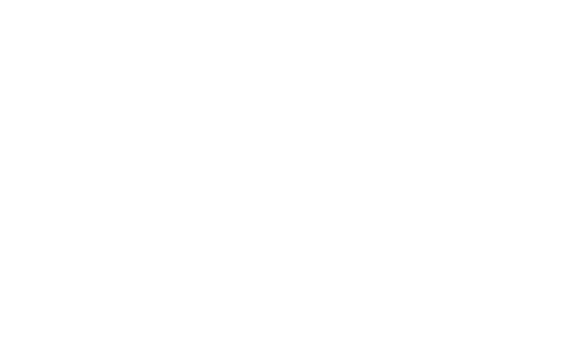

In [150]:
import matplotlib.pyplot as plt
from traffic.drawing import EuroPP, PlateCarree, countries, rivers
with plt.style.context('traffic'):
    
    fig, ax = plt.subplots(
        subplot_kw=dict(projection=EuroPP())
    )
    ax.set_extent((-7, 13, 42, 50))

    # no specific method for that in traffic
    # but switch back to pandas DataFrame for manual plot
    vuelos.plot(ax)